In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [2]:
import sys
sys.path.append('../../..')

In [3]:
import torch
import numpy as np

from magrec.prop.Fourier import FourierTransform2d
from magrec.prop.Kernel import HarmonicFunctionComponentsKernel, MagneticFieldToCurrentInversion2d
from magrec.misc.plot import plot_n_components
from magrec import __datapath__

In [4]:
from magrec.misc.load import load_matlab_data

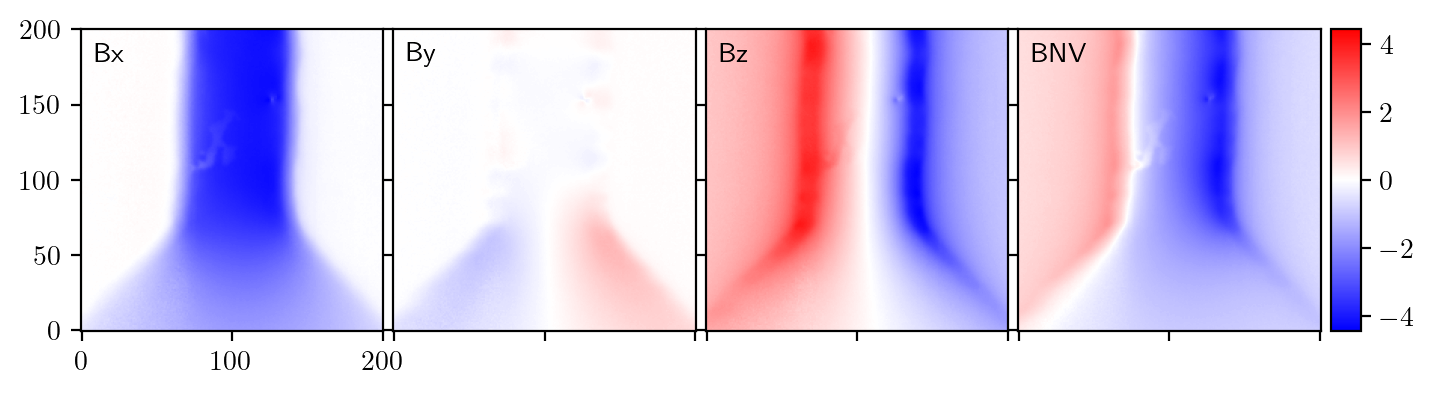

In [129]:
Bx = np.loadtxt(__datapath__ / "ExperimentalData" / "NbWire" / "Bx.txt" )
By = np.loadtxt(__datapath__ / "ExperimentalData" / "NbWire" / "By.txt" )
Bz = np.loadtxt(__datapath__ / "ExperimentalData" / "NbWire" / "Bz.txt" )

B = np.empty(shape=(4,201,201))

setTheta = np.deg2rad(54.7)
setPhi = np.deg2rad(45)

unv = [np.sin(setTheta) * np.cos(setPhi),
        np.sin(setTheta) * np.sin(setPhi),
        np.cos(setTheta)]

B[0] = Bx
B[1] = By
B[2] = Bz
B[3] = Bx*unv[0] + By*unv[1] + Bz*unv[2]

B_NV = torch.from_numpy(Bx*unv[0] + By*unv[1] + Bz*unv[2] )
B_NV.shape  # (39, 141) — notice that it is probably bad to have an odd number of pixels

plot_n_components(B, labels=[r'Bx', 'By', 'Bz', 'BNV'], cmap="bwr")

In [130]:
# data from inspecting the matlab file  
dx=0.408  # in μm
dy=0.408

# data from the .pptx shared by the authors
theta = np.rad2deg(setTheta)  # degrees
phi = np.rad2deg(setPhi)    # degrees

ft = FourierTransform2d(B_NV.shape, dx=dx, dy=dy)
kernel = HarmonicFunctionComponentsKernel.define_kernel_matrix(ft.kx_vector, ft.ky_vector, theta=theta, phi=phi)

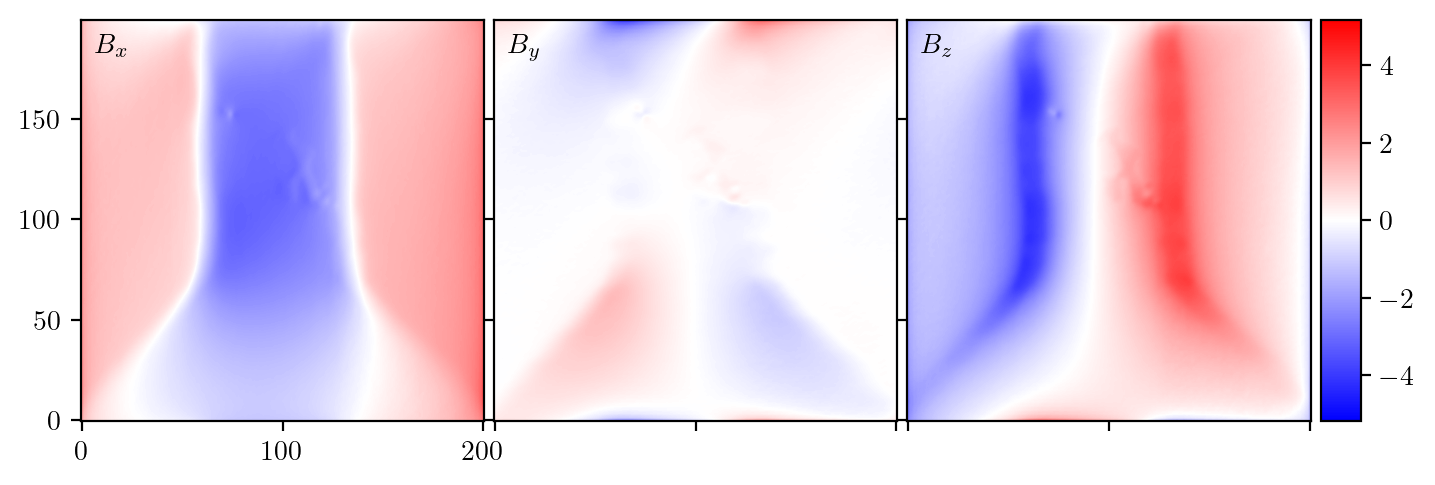

In [131]:
b_NV = ft.forward(torch.flipud(B_NV), dim=(-2, -1))
b = torch.einsum("jkl,kl-> jkl", kernel, b_NV)
B = ft.backward(b, dim=(-2, -1))
B.shape # (3, n_x, n_y) <- this should give real vector field map
plot_n_components(B, symmetric=True, labels=[r"$B_x$", r"$B_y$", r"$B_z$"], cmap="bwr", 
imshow_kwargs={"interpolation": "bicubic"})

In [41]:
from magrec.prop.Propagator import FourierPadder

In [45]:
FourierPadder.pad_reflective2d(B_NV).shape

torch.Size([282, 78])

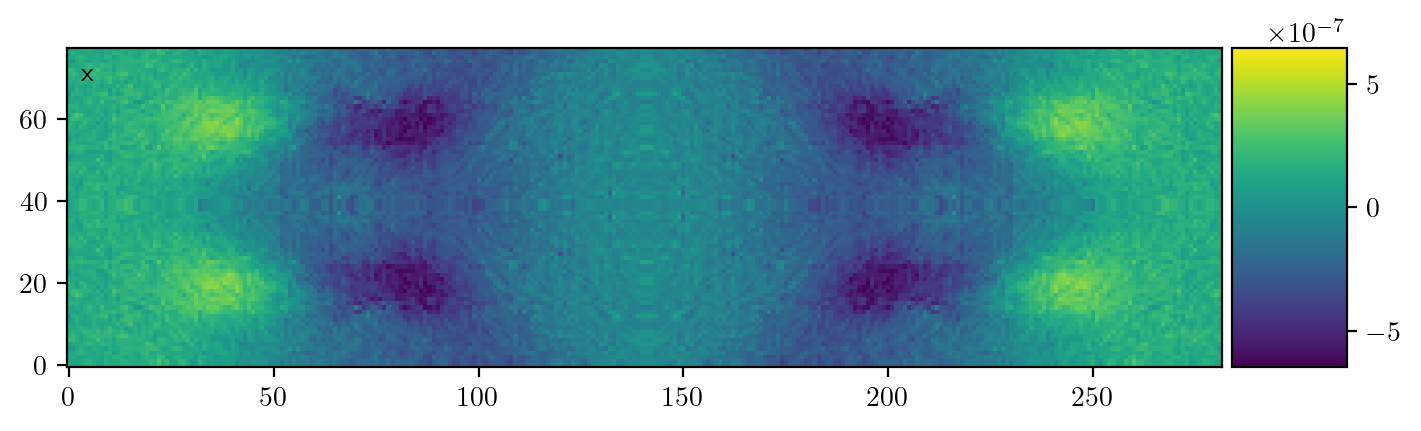

In [47]:
plot_n_components(FourierPadder.pad_reflective2d(B_NV))

In [71]:
padded_B_NV = FourierPadder.pad_zeros2d(B_NV)
ft = FourierTransform2d(padded_B_NV.shape, dx=dx, dy=dy)
b_NV = ft.forward(padded_B_NV, dim=(-2, -1))
kernel = HarmonicFunctionComponentsKernel.define_kernel_matrix(ft.kx_vector, ft.ky_vector, theta=theta, phi=phi)
b = torch.einsum("cjk,jk->cjk", kernel, b_NV)
B = ft.backward(b, dim=(-2, -1))
B.shape # (3, n_x, n_y) <- this should give real vector field map

torch.Size([3, 282, 78])

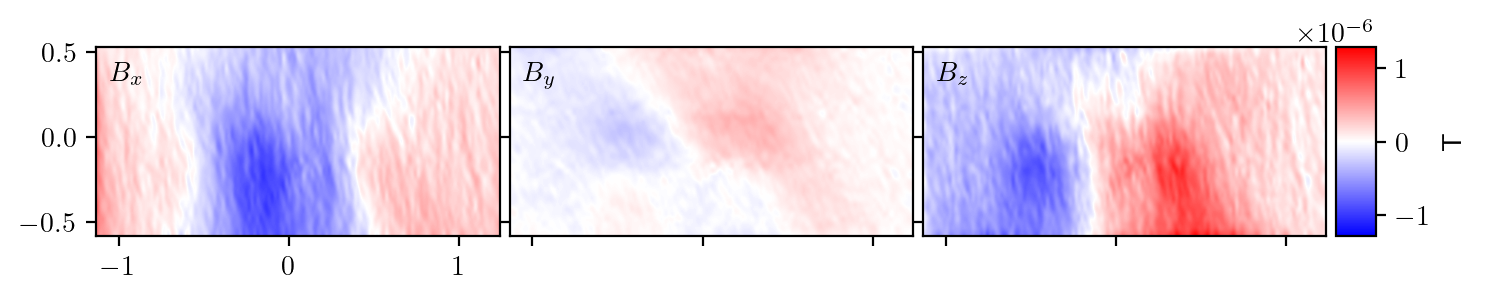

In [63]:
plot_n_components(B[:, :141, :39], symmetric=True, labels=[r"$B_x$", r"$B_y$", r"$B_z$"], cmap="bwr", units="T",
imshow_kwargs={
    "extent": [x_vector.min(), x_vector.max(), y_vector.min(), y_vector.max()],
    "interpolation": "bicubic",
    })

In [73]:
height = 0.15 # in μm
layer_thickness = 1 # put 1 for now to get result per μm
inversion_kernel = MagneticFieldToCurrentInversion2d.define_kernel_matrix(ft.kx_vector, ft.ky_vector, height=height, layer_thickness=layer_thickness)

In [96]:
bxby = b[:2, :, :].type(dtype=torch.complex64)
jxjy = torch.einsum('vcjk,cjk->vjk', inversion_kernel, bxby)
JxJy = ft.backward(jxjy, dim=(-2, -1))

In [83]:
JxJy.shape

torch.Size([2, 282, 78])

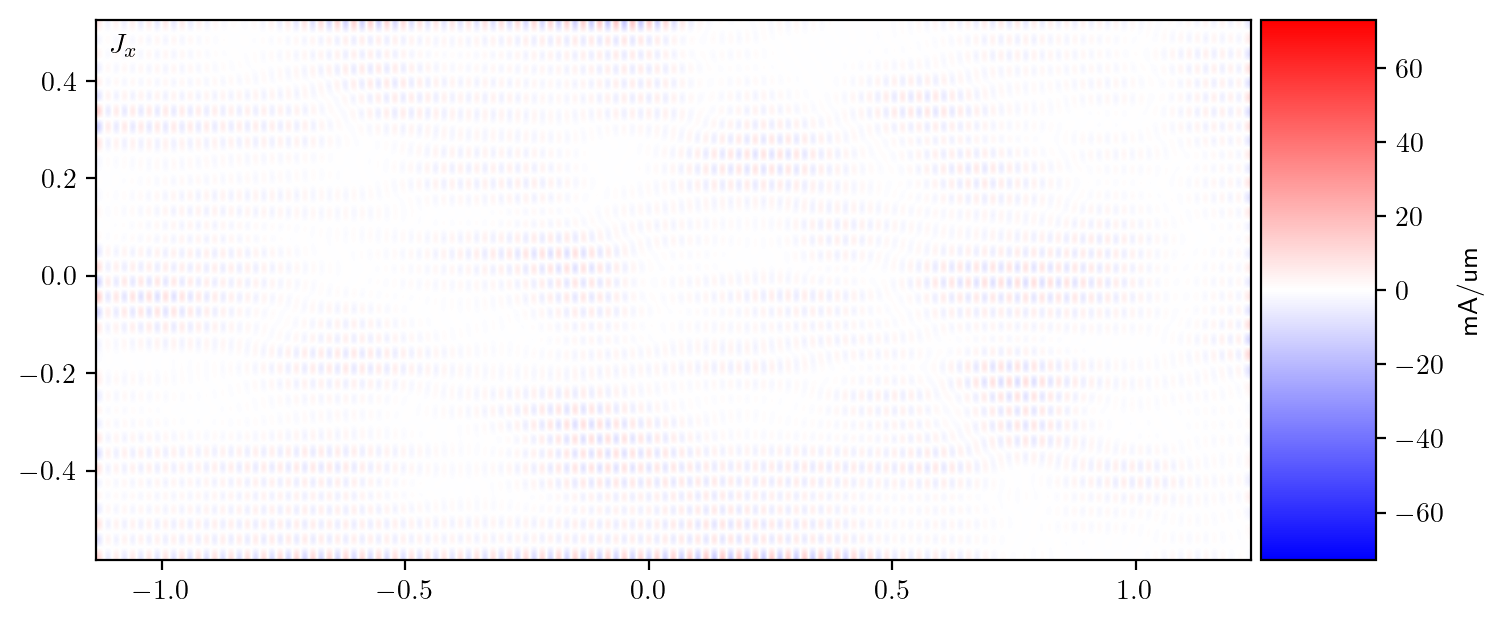

In [97]:
plot_n_components(JxJy[0, :141, :38] * 1e-6, symmetric=False, labels=[r"$J_x$", r"$J_y$"], cmap="bwr", units="mA/um",
imshow_kwargs={
    "extent": [x_vector.min(), x_vector.max(), y_vector.min(), y_vector.max()],
    "interpolation": "bicubic",
    })

In [87]:
JxJy

tensor([[[ 15763344.0000, -23948802.0000,  25709346.0000,  ...,
           -5283201.5000,   6349774.5000,  -8692539.0000],
         [-17104634.0000,  25314730.0000, -26965918.0000,  ...,
            6183522.5000,  -7409265.0000,   9966684.0000],
         [ 18343946.0000, -26521220.0000,  28081724.0000,  ...,
           -7095861.0000,   8478951.0000, -11221012.0000],
         ...,
         [-11500780.0000,  19077952.0000, -21168734.0000,  ...,
            2985673.0000,  -3628915.7500,   5236686.5000],
         [ 12902952.0000, -20772102.0000,  22765362.0000,  ...,
           -3657974.2500,   4426398.5000,  -6279704.0000],
         [-14344208.0000,  22419432.0000, -24298688.0000,  ...,
            4430074.5000,  -5341593.5000,   7445161.0000]],

        [[ 36595136.0000, -29621306.0000,  13000331.0000,  ...,
          -29764824.0000,  33611696.0000, -37771612.0000],
         [-34734216.0000,  28345746.0000, -12604497.0000,  ...,
           29125870.0000, -32796704.0000,  36504816.0000],
